In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
import matplotlib.dates as dates
from datetime import datetime

from dataset import Dataset


## The dataset

The dataset we're working with covers a variety of cabs rides for Uber & Lyft and their prices for the given location. 
Dataset source: https://www.kaggle.com/datasets/ravi72munde/uber-lyft-cab-prices?rvi=1
The dataset has 573k instances and 9 columns each but we would be filtering it down to 13k to easily train the model.
We will be working with the following columns:
* distance (distance between source and destination)              
* cab_type (Uber or Lyft)            
* destination         
* source              
* surge_multiplier (the multiplier by which price was increased, default 1)  
* name                
* price (price estimate for the ride in USD)               


In [3]:
load_dataset = pd.read_csv("cab_rides.csv")

Datas = Dataset(load_dataset)
dataset = Datas.getDataset()

In [4]:
# Getting all outliers
outliers_list = Datas.get_outliers()
surge_multiplier_outliers = outliers_list[0]
price_outliers =  outliers_list[1]

print(surge_multiplier_outliers, price_outliers)

                         distance cab_type              destination  \
time_stamp                                                            
2018-11-26 05:28:07.501      2.38     Lyft         Haymarket Square   
2018-11-26 05:50:01.091      3.17     Lyft       Financial District   
2018-11-26 06:40:32.659      2.64     Lyft              Beacon Hill   
2018-11-26 12:50:10.145      2.81     Lyft                 West End   
2018-11-26 12:50:10.412      3.21     Lyft            North Station   
...                           ...      ...                      ...   
2018-12-18 10:00:15.949      3.14     Lyft        Boston University   
2018-12-18 10:50:07.524      1.96     Lyft                 Back Bay   
2018-12-18 12:05:10.257      1.08     Lyft  Northeastern University   
2018-12-18 15:20:12.510      1.20     Lyft         Haymarket Square   
2018-12-18 18:15:10.454      3.23     Lyft                 Back Bay   

                                          source  surge_multiplier  \
time_s

<h2>Data Presentation</h2>

In [5]:
dataset.head()

,distance,cab_type,destination,source,surge_multiplier,name,price
time_stamp,,,,,,,
2018-11-26 03:40:47.739,1.78,Lyft,Haymarket Square,Theatre District,1.0,Lyft,9.0
2018-11-26 04:40:56.855,3.15,Uber,Northeastern University,West End,1.0,WAV,11.5
2018-11-26 04:41:37.423,2.32,Uber,Fenway,Beacon Hill,1.0,Taxi,NaN
2018-11-26 04:41:37.659,1.25,Lyft,West End,North End,1.0,Shared,3.5
2018-11-26 04:43:18.387,1.53,Lyft,Theatre District,North End,1.0,Lux Black,22.5


Loading BokehJS ...

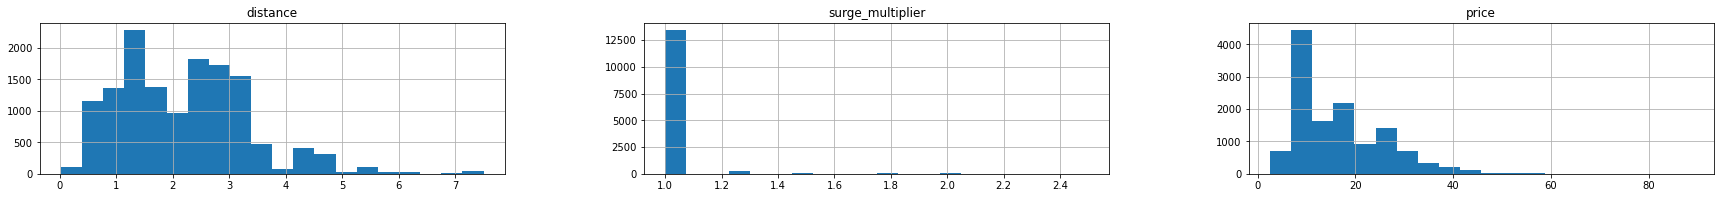

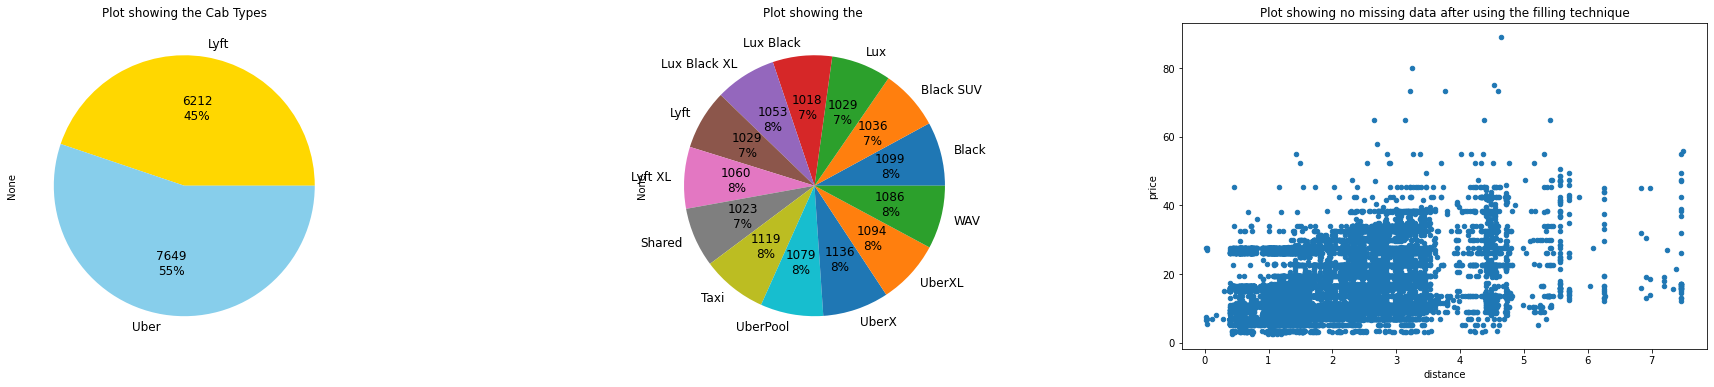

In [6]:
from dataset_plt import DatasetPlot

dataset_plot =  DatasetPlot(dataset)
dataset_plot.plot_dataset()

In [7]:
dataset_plot.bokeh_plot()

<h3>Discussion of Data Visualization</h3>
* Fig 1: Histogram plot of distance. It gives a sense of the frequency distribution of teh ride distance. From the plot we can see that the most frequent ride distance is about 1.5km and the frequencies of long rides above 3.5km is very scarce.<br/><br/>
* Fig 2: Histogram plot of the surge multiplier. This shows the frequency distribution of the surge multiplier. From the plot we can see that on most occassion there is no surge as the default surge multiplier is 1 and on very rare occassions there can be surges above 1.0.<br/><br/>
* Fig 3: Histogram plot of price. This shows the frequency distribution of the price. From the plot we can deduce that most of the cab rides are less than USD 20. <br/><br/>
* Fig 4: Pie Chart plot: This shows the frequency distribution of the cab_types based on the categories. From the plot we can see that we have two categories of cab types: Uber and Lyft. With Uber having 10% more cab rides in this sample than Lyft.<br/><br/>
 * Fig 5: Pie Chart plot:  This shows the frequency distribution of the name based on the categories.<br/></br>
* Fig 6: Scatter plot: Shows the relationship between the distance and price.

In [8]:
print("Missing Data")
print(dataset.isna().sum())

print("----------")
print("Count of surge multiplier outliers: ", len(surge_multiplier_outliers.index))
print("Count of price outliers: ", len(price_outliers.index))

Missing Data
distance               0
cab_type               0
destination            0
source                 0
surge_multiplier       0
name                   0
price               1119
dtype: int64
----------
Count of surge multiplier outliers:  191
Count of price outliers:  1379


<h3>Treating outliers as missing data values in the dataset</h2>

In [9]:
# Treating outliers as missing data values in the dataset
dataset.loc[surge_multiplier_outliers.index, "surge_multiplier"] = np.nan 
dataset.loc[price_outliers.index, "price"] = np.nan 

<h3>Discussion of Data Scaling Techniques</h3>
<ul>
<li>The MinMax scaler shifts the distribution of the values to a smaller scale by using the maximum and minimum values as references.</li>
<li>The Z-score scaler shifts the distribution of the values so they can be within the range of 0 and 1.</li>
<li>The MaxAbs scaler shifts the distribution of the values so they can be within the range of -1 and 1. It uses the maximum value as reference.</li>
<li>The Robust scaler scales the data according to the InterQuantile Range.</li>
</ul>


## Handling Missing Data and Outliers

In [10]:
# Transforming the categorical values in the dataset to numerical values
from sklearn import preprocessing
new_dataset = dataset.copy()
cat_columns = new_dataset.select_dtypes('object').columns.tolist()

cols_list = dataset.select_dtypes('number').columns.tolist()

for col in new_dataset[cat_columns]:
    le = preprocessing.LabelEncoder()
    new_dataset[col] = le.fit_transform(new_dataset[col])


<h3>Discussion of Handling Missing Data With Pandas FFILL</h3>

- The problem with using ffill is because the technique fills the missing values in the column by using the column value in the previous column on the same row. In reality, the technique will use distance to fill the missing surge multiplier and price. 

<h3>Discussion for Handling Missing Data With Regressor</h3>
<p>The preferred combination is KNN and Normalizer Scaler, because the combination has the lowest mean cross validation performance value. </p>
<p>The justification for using mean squared error as the evaluation metric is because we are dealing with a regression problem and also because of how it helps us to know the mean of the difference between the actual and the predicted values.</p>

In [11]:
# Building the final model with the chosen regressor and data scaling technique
X_scaled = Normalizer().fit_transform(X)
regressor = KNeighborsRegressor()
regressor.fit(X_scaled, Y)

dddataset = dataset.copy()

# Transforming the categorical values in the dataset to numerical values
for col in dddataset[cat_columns]:
    le = preprocessing.LabelEncoder()
    dddataset[col] = le.fit_transform(dddataset[col])

# Predicting missing values for the surge multiplier & price
cols_to_predict = ["surge_multiplier", "price"]
cols_to_fill = ["price", "surge_multiplier"]

surge_predict = []
price_predict = []

for i in range(len(cols_to_predict)):
  # Creating a new dataset to work with at each iteration
  fill = dddataset.copy()

  # Filling the none values of the opposite missing column e.g to predict surge 
  # multiplier, we fill all missing values for price and vice versa
  fill[cols_to_fill[i]].fillna(fill[cols_to_fill[i]].mean(), inplace=True)

  # Making the column to predict the last column for easy selection
  popped_column = fill.pop(cols_to_predict[i])
  fill = pd.concat([fill, popped_column], axis = 1)
  
  # Selecting the missing rows of the column to predict
  missing = fill[fill[cols_to_predict[i]].isnull()]

  # Dropping the missing rows on the column to predict
  fill = fill.dropna()

  # Selecting the features (X) and the target (Y)
  X = fill.iloc[:, :-1].values
  Y = fill.iloc[:, -1].values

  # Using our preferred scaler to fit_transform the features
  X_scaled = Normalizer().fit_transform(X)
  regressor = KNeighborsRegressor()
  regressor.fit(X_scaled, Y)

  # Selecting the feature columns to predict the target in the current iteration
  X_test = missing.iloc[:, :-1].values

  # Fitting the features
  X_test_scaled = Normalizer().fit_transform(X_test)

  # Finally predicting the missing values
  predicted = regressor.predict(X_test_scaled)

  if i == 0:
    surge_predict = predicted
  else:
    price_predict = predicted

# Filling the missing and outlier data from the original dataset
final_dataset = dataset.copy()

# Selecting the index of the missing surge_multiplier values
missing_surge = final_dataset['surge_multiplier'].isna()

# Adding the predicted surge_multiplier values to the dataset
final_dataset.loc[missing_surge, "surge_multiplier"] = surge_predict

# Selecting the index of the missing price values
missing_price = final_dataset['price'].isna()

# Adding the predicted price values to the dataset
final_dataset.loc[missing_price, "price"] = price_predict

# Showing the number of missing values on the dataset which is now zero
final_dataset.isna().sum()

NameError: name 'Normalizer' is not defined

## Feature Selection

Baseline Model Performance Mean:  3.1273515806959398
Sequential Feature Selection Performance Mean For 1 Feature(s):  14.864620332381566
Sequential Feature Selection Performance Mean For 2 Feature(s):  3.7411768543869477
Sequential Feature Selection Performance Mean For 3 Feature(s):  3.179621286218529
Sequential Feature Selection Performance Mean For 4 Feature(s):  3.0423489418391836
Sequential Feature Selection Performance Mean For 5 Feature(s):  3.0410768866960263
Univariate Feature Selection Performance Mean For 1 Feature(s):  14.796942345368057
Univariate Feature Selection Performance Mean For 2 Feature(s):  3.751274727938808
Univariate Feature Selection Performance Mean For 3 Feature(s):  3.7379734571993697
Univariate Feature Selection Performance Mean For 4 Feature(s):  3.1829875330638835
Univariate Feature Selection Performance Mean For 5 Feature(s):  3.1945678001216633
Univariate Feature Selection Performance Mean For 6 Feature(s):  3.131055139756745


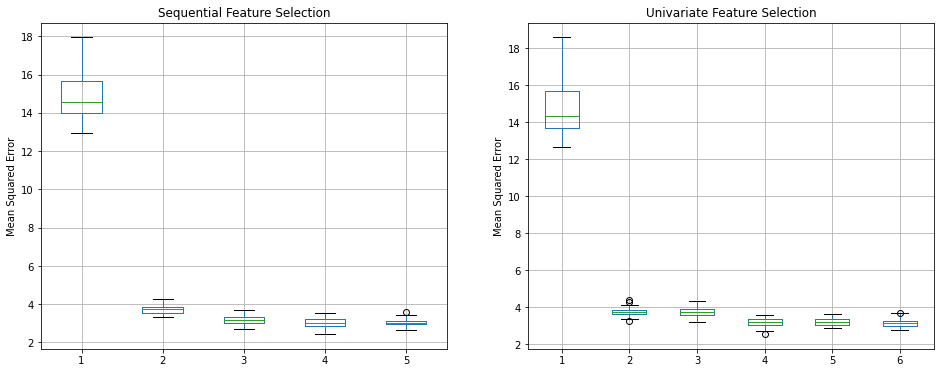

In [ ]:
# Target value to forecast is price
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import chi2, f_classif, mutual_info_regression
from sklearn.feature_selection import RFE

# Creating a copy of the final dataset values without missing or outlier values
ffinal_dataset = final_dataset.copy()

results = {}
columns = ffinal_dataset.columns

# Transforming the categorical values in the dataset to numerical values
for col in ffinal_dataset[cat_columns]:
    le = preprocessing.LabelEncoder()
    ffinal_dataset[col] = le.fit_transform(ffinal_dataset[col])

X = ffinal_dataset.iloc[:, :-1].values
Y = ffinal_dataset.iloc[:, -1].values

#Baseline Model
scores = cross_val_score(KNeighborsRegressor(), X, Y, scoring=score, cv=cv_fold, n_jobs=-1)
print("Baseline Model Performance Mean: ", scores.mean())

# Using Sequential Feature
fig, ax = plt.subplots(1, 2, figsize=(16, 6))    
ax.flatten()

for i in range(5):
    sfs = SequentialFeatureSelector(KNeighborsRegressor(), n_features_to_select=i + 1, direction="forward")
    X_sel = sfs.fit_transform(X, Y)
    _scores = cross_val_score(KNeighborsRegressor(), X_sel, Y, scoring=score, cv=cv_fold, n_jobs=-1)
    results[f'{i+1}'] = _scores
    print("Sequential Feature Selection Performance Mean For",i+1, "Feature(s): ", _scores.mean())
df_res = pd.DataFrame(results).copy()
df_res.boxplot(ax=ax[0])
ax[0].set_title(f"Sequential Feature Selection");
ax[0].set_ylabel("Mean Squared Error")


# Using Univariate feature selection
results = {}
for i in range(6):
    sel = SelectKBest(score_func=mutual_info_regression, k=i + 1)
    X_sel = sel.fit_transform(X, Y)
    _scores = cross_val_score(KNeighborsRegressor(), X_sel, Y, scoring=score, cv=cv_fold, n_jobs=-1)
    results[f'{i+1}'] = _scores    
    print("Univariate Feature Selection Performance Mean For",i+1, "Feature(s): ", _scores.mean())
df_res = pd.DataFrame(results).copy()
df_res.boxplot(ax=ax[1])
ax[1].set_title(f"Univariate Feature Selection");
ax[1].set_ylabel("Mean Squared Error")

plt.show()

### Discussion of Feature Selection
<p>There is a slight improvement in the performance over the baseline model when the Sequential Feature Selection used 4 and 5 of the features for fitting the model.</p>

<p>The Sequential Feature Selection technique seems to have a better performance overall over the Univariate Feature Selection technique. The reason the Sequential Feature Selection performs better is because of it greedy approach, where at each stage the regressor chooses the best feature to add or remove based on the cross-validation score of the regressor.</p>

<p>Also, it was noticed that the model does not perform well on any of the data scalers tried out which was why we did not use it for fitting the features in our baseline model and others moving forward</p>